In [1]:
from astropy.table import Table
import pdb
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib
%matplotlib inline

/home/oxymoronic/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [41]:
matplotlib.rcParams.update({'font.size': 30, 
							'font.family': 'STIXGeneral', 
							'mathtext.fontset': 'stix',
							'xtick.labelsize':24,
							'ytick.labelsize':24,
							'xtick.major.width':2,
							'ytick.major.width':2,
							'axes.linewidth':2,
							'lines.linewidth':3,
							'legend.fontsize':20})


In [3]:
clumpy1 = Table.read('../data/clumpy_coadd_DR12ancillary_stellarmasses_highzgal.csv')
clumpy2 = Table.read('../data/clumpy_coadd_final75_gzh_dr12ancillary.fits')
print len(clumpy1), len(clumpy2)

62 75


In [4]:
len(set(clumpy1['OBJID'])&set(clumpy2['OBJID']))

61

In [5]:
GSWLC = Table.read("../data/GSWLC-X1.dat", format='ascii.fast_no_header')

In [6]:
# why the FUCK don't they put the damn column headers in themselves?!! How obnoxious.
colnames = ['DR12_OBJID', 'GLXID', 'plate', 'MJD', 'fiber ID', 'RA', 'DEC', 'z', 'chi_sq', 
           'M*', 'M*_err', 'SFR', 'SFR_err', 'A_FUV', 'A_FUV_err', 'A_B', 'A_B_err', 'A_V',
           'A_V_err', 'flag_sed', 'UV_survey', 'SFR_wise', 'flag_wise', 'SFR_unwise',
           'flag_unwise', 'flag_mgs']

for i, name in enumerate(colnames):
    GSWLC.rename_column('col{}'.format(i+1), name)

In [7]:
#clumpy2.colnames

In [8]:
catalog = SkyCoord(ra=GSWLC['RA']*u.deg, dec=GSWLC['DEC']*u.deg)
sample = SkyCoord(ra=clumpy2['DR12_RA']*u.deg, dec=clumpy2['DR12_DEC']*u.deg)
idx, d2d, d3d = sample.match_to_catalog_sky(catalog)

In [9]:
close_mask = (catalog[idx].separation(sample)<20*u.arcsec)
close_matches_in_clumpy = clumpy2[close_mask]
close_matches_in_GSWLC = GSWLC[idx[close_mask]]

#for id1, id2, sep in zip(close_matches_in_GSWLC['DR12_OBJID'], close_matches_in_clumpy['DR12_OBJID'], 
#                         Angle(d2d[close_mask], u.arcsec)):
#    print id1, id2, sep

In [10]:
from astropy.coordinates import Angle
print Angle(d2d, u.arcsec)[close_mask]

[u'0.197704arcsec' u'0.123435arcsec' u'1.39532arcsec' u'0.205284arcsec'
 u'0.140809arcsec' u'0.133922arcsec' u'0.0565079arcsec' u'0.18016arcsec'
 u'0.0846442arcsec' u'4.50877arcsec' u'0.051981arcsec' u'5.0384arcsec'
 u'0.223543arcsec' u'0.107302arcsec' u'0.175993arcsec' u'0.345666arcsec'
 u'0.1476arcsec' u'0.450691arcsec' u'4.18483arcsec' u'0.260011arcsec'
 u'0.0274145arcsec' u'0.329988arcsec' u'0.21604arcsec' u'0.0938457arcsec'
 u'0.0335853arcsec' u'0.127261arcsec' u'0.484988arcsec' u'0.166769arcsec'
 u'0.172837arcsec' u'0.257097arcsec' u'0.144146arcsec' u'0.399588arcsec'
 u'0.218779arcsec' u'0.474903arcsec' u'3.71435arcsec' u'0.0254519arcsec'
 u'0.108859arcsec' u'0.084887arcsec' u'8.92643arcsec' u'0.0766391arcsec'
 u'1.49449arcsec' u'0.111453arcsec' u'5.54636arcsec' u'0.225476arcsec'
 u'0.401961arcsec' u'0.0563168arcsec' u'13.9507arcsec' u'0.24902arcsec'
 u'0.061351arcsec' u'0.0982607arcsec' u'0.135838arcsec' u'0.179322arcsec'
 u'0.074443arcsec' u'0.432684arcsec' u'2.70141arcsec' u'0

In [11]:
print len(close_matches_in_clumpy)
print np.sum(close_matches_in_clumpy['AVG_Z']<=0.06)

64
46


### I've come to realize that the DR12 OBJID I have for the clumpy galaxies are not good.
When you enter them into SDSS Navigator the correct subject comes up but it's missing 
the link to the interactive spectra section and additional information. I wonder if I didn't get the Primary Object ID or something.... 
### Anyway. I am going overwrite them with those that I found in this GSWL catalog

In [12]:
clumpy2['DR12_OBJID'][close_mask] = GSWLC['DR12_OBJID'][idx[close_mask]]

In [13]:
print "Those in clumpy2 with matches to GSWLC:", len(set(clumpy2['DR12_OBJID']) & set(GSWLC['DR12_OBJID']))
print "Those in clumpy1 with matches to GSWLC:", len(set(clumpy1['DR12_OBJID']) & set(GSWLC['DR12_OBJID']))

Those in clumpy2 with matches to GSWLC: 64
Those in clumpy1 with matches to GSWLC: 54


In [14]:
lowz = close_matches_in_clumpy[close_matches_in_clumpy['AVG_Z']<=0.06]
lowz_GSWLC = close_matches_in_GSWLC[close_matches_in_GSWLC['z']<=0.06]


### Half the lowz sample doesn't have 22 um detection in WISE (flag_unwise = 5)

(array([ 22.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  24.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

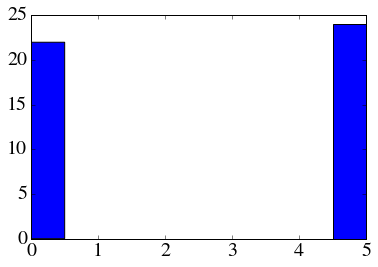

In [15]:
plt.hist(lowz_GSWLC['flag_unwise'])

### ~ 3 have SED fitting with chi square > 30 

(array([ 42.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

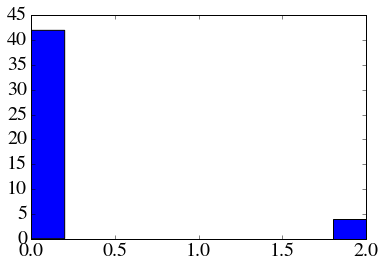

In [16]:
plt.hist(lowz_GSWLC['flag_sed'])

### Most subjects have medium-depth UV imaging, a few have only shallowest; a few have the deepest depth

(array([  3.,   0.,   0.,   0.,   0.,  34.,   0.,   0.,   0.,   9.]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 10 Patch objects>)

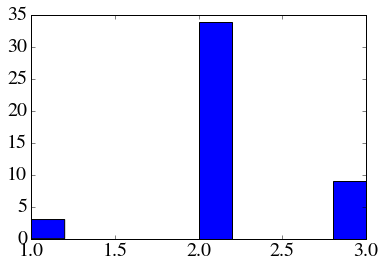

In [17]:
plt.hist(lowz_GSWLC['UV_survey'])

## SFR vs Stellar Mass for 34 clumpy gals with z < 0.04

42


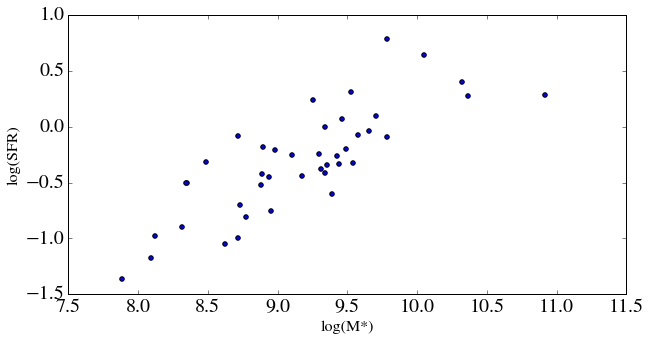

In [20]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)

ax.scatter(lowz_GSWLC['M*'][lowz_GSWLC['flag_sed']==0],
           lowz_GSWLC['SFR'][lowz_GSWLC['flag_sed']==0])
ax.set_xlabel('log(M*)', fontsize=16)
ax.set_ylabel('log(SFR)', fontsize=16)

print len(lowz_GSWLC['M*'][lowz_GSWLC['flag_sed']==0])

20


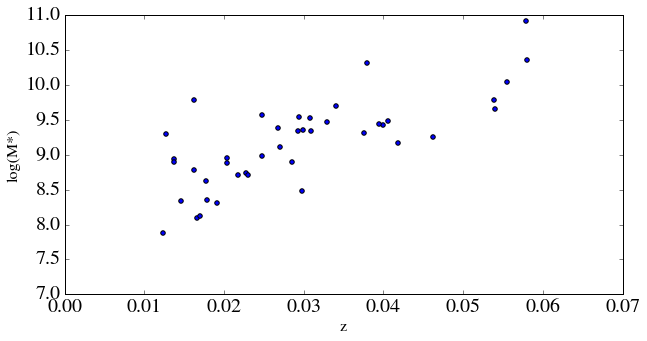

In [21]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)

ax.scatter(lowz_GSWLC['z'][lowz_GSWLC['flag_sed']==0],
           lowz_GSWLC['M*'][lowz_GSWLC['flag_sed']==0])
ax.set_ylabel('log(M*)', fontsize=16)
ax.set_xlabel('z', fontsize=16)
ax.set_ylim(7,11)

print np.sum( (lowz_GSWLC['M*']>=9.) & (lowz_GSWLC['M*']<=10.) )

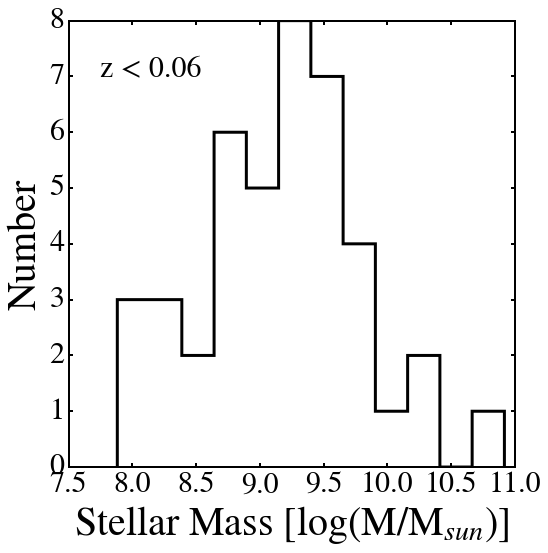

In [53]:
matplotlib.rcParams.update({'font.size': 40, 
							'font.family': 'STIXGeneral', 
							'mathtext.fontset': 'stix',
							'xtick.labelsize':30,
							'ytick.labelsize':30,
							'xtick.major.width':2,
							'ytick.major.width':2,
							'axes.linewidth':2,
							'lines.linewidth':3,
							'legend.fontsize':20})

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.hist(lowz_GSWLC['M*'][lowz_GSWLC['flag_sed']==0], histtype='step', color='k', bins=12, lw=3)

ax.set_xlabel(r'Stellar Mass [log(M/M$_{sun}$)]')
ax.set_ylabel('Number')

ax.text(7.75, 7, 'z < 0.06', fontsize=30)

plt.savefig('clumpy_stellar_mass_distribution.png')

### Gathered more stellar masses from CasJobs. Couldn't find masses for all 75. 
Of those that I could find, it seems ~50 overlap with GSWL catalog. 

In [70]:
from astropy.table import join

combo = join(clumpy1, close_matches_in_GSWLC, keys='DR12_OBJID')

In [46]:
masses = ['PortSF_logMass', 'WBC03_mass', 'GWD_logMass', 'GWND_logMass', 'M*']
combo_clean = combo[combo['M*']>=0.]

avg_mass, std_mass = [], []
for gal in combo_clean[masses]:
    masses = np.array([gal[i] for i in range(len(masses))])
        
    avg_mass.append(np.mean(masses))
    std_mass.append(np.std(masses))

### Of those, 25 have z < 0.04 and have stellar masses from ALL sources that I searched

25


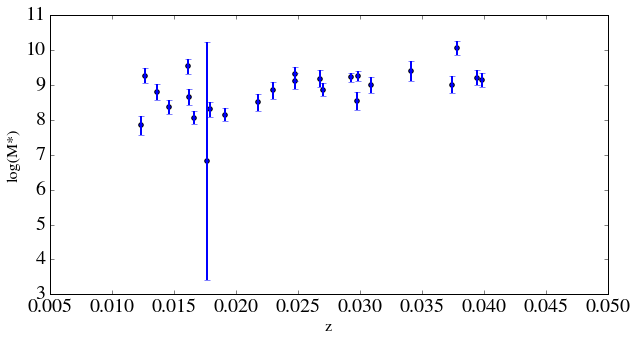

In [69]:
lowz_mask = combo_clean['z_1']<=0.04
print len(combo_clean[lowz_mask])

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)

ax.scatter(combo_clean['z_1'][lowz_mask], np.array(avg_mass)[lowz_mask], marker='o')
ax.errorbar(combo_clean['z_1'][lowz_mask], np.array(avg_mass)[lowz_mask], 
            yerr=np.array(std_mass)[lowz_mask], ls='None')
ax.set_ylabel('log(M*)', fontsize=16)
ax.set_xlabel('z', fontsize=16)